In [ ]:
! pip install -q tensorflow==2.4.1 tensorflow-quantum

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 7.8 MB 44.5 MB/s 
     |████████████████████████████████| 2.9 MB 73.9 MB/s 
     |████████████████████████████████| 462 kB 77.0 MB/s 
     |████████████████████████████████| 3.8 MB 73.9 MB/s 
     |████████████████████████████████| 5.6 MB 68.3 MB/s 
     |████████████████████████████████| 90 kB 11.7 MB/s 
     |████████████████████████████████| 90 kB 11.5 MB/s 
     |████████████████████████████████| 100 kB 11.7 MB/s 
     |████████████████████████████████| 1.3 MB 68.1 MB/s 
     |████████████████████████████████| 380 kB 77.7 MB/s 
     |████████████████████████████████| 1.5 MB 90.6 MB/s 
     |████████████████████████████████| 93 kB 2.0 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq


import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from statsmodels.tsa.api import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv("numerical_df_corrected.csv", index_col="Date")

In [ ]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))
test_split = int((split_fraction+ 0.1) * int(df.shape[0]))

step = 1

past = 1
future = 1
learning_rate = 0.001
batch_size = 1
epochs = 100


def normalize(data, train_split):
    # data_mean = data[:train_split].mean(axis=0)
    # data_std = data[:train_split].std(axis=0)
    # return (data - data_mean) / data_std

    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)

    return df.values

def smooth(dataset, train_split, smooth_level = 0.1):
  for column in dataset.columns:
    data = dataset[column]
    exp = ExponentialSmoothing(data[:train_split])
    exp_model = exp.fit(smoothing_level=0.1)
    result = exp_model.fittedvalues
    dataset[column][:train_split] = result
    return dataset

In [ ]:
date_time_key = "Date"
print(
    "The selected parameters are:",
    ", ".join([df.columns[i] for i in [0, 1, 2, 3, 4, 5]]),
)
cols = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
selected_features = [df.columns[i] for i in [0, 1, 2, 3, 4, 5]]
features = df[selected_features]
features.set_index(df.index, inplace=True)
#print(features.head())

features = smooth(features, train_split, 0.1)
#print(features.head())

#features = normalize(features, train_split)
features = pd.DataFrame(features.values)

The selected parameters are: PS_Q_DAY, TPS_Q1_DAY, TWAS_DAF_QIN_DAY, DIGESTED_SLUDGE_QOUT_DAY, BIOGAS_PRODUCTION_Q_DAY, DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
x = features[[0,1,2,3,5]]
y = features[[4]]

x = x/(x.to_numpy().max())# Sclaing data to 0 ->1 for quantum encoding
y = y/(y.to_numpy().max())



In [ ]:
# Quantum CNN
def convert_data(data, qubits, test=False):
    cs = []
    column_list = [0,1,2,3,5]
    #print(data.iloc[4])
    for i in range(0,len(data)):
        
        cir = cirq.Circuit()

        for j in column_list:
            #print(f"i: {i} and j: {j}")
            if j==5:
              cir += cirq.rx(data.iloc[i][j] * np.pi).on(qubits[j-1])
              #print("Hello1-5")
              cir += cirq.ry(data.iloc[i][j] * np.pi).on(qubits[j-1])
            else:
              cir += cirq.rx(data.iloc[i][j] * np.pi).on(qubits[j])
              #print("Hello1")
              cir += cirq.ry(data.iloc[i][j] * np.pi).on(qubits[j])
        cs.append(cir)
    SVGCircuit(cir)
    if test:
        return tfq.convert_to_tensor([cs])
    return tfq.convert_to_tensor(cs)

def encode(data, labels, qubits):
    X_train =  data.iloc[:train_split-1]# 80:10:10 Split
    y_train = labels.iloc[:train_split-1]
    X_val =  data.iloc[train_split:test_split-1]
    y_val = labels.iloc[train_split:test_split-1]
    X_test =  data.iloc[test_split:]
    y_test = labels.iloc[test_split:]
    
    return convert_data(X_train, qubits), convert_data(X_val,qubits), convert_data(X_test, qubits), y_train, y_val, y_test


In [ ]:
def one_qubit_unitary(bit, symbols):
        return cirq.Circuit(
            cirq.X(bit)**symbols[0],
            cirq.Y(bit)**symbols[1],
            cirq.Z(bit)**symbols[2])

def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit



In [ ]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')

    model_circuit += quantum_conv_circuit(qubits, symbols[:15])# 15
    model_circuit += quantum_pool_circuit(qubits[:1], qubits[1:],# 6
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[1:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[1:3], qubits[3:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[3:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[3]], [qubits[4]],
                                          symbols[57:63])
    return model_circuit
    

qs = [cirq.GridQubit(0, i) for i in range(5)]


X_train, X_val, X_test, y_train, y_val, y_test = encode(x, y, qs)
c = create_model_circuit(qs)
print(c)


#v_history = vqc.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), callbacks=[callback])


(0, 0): ───X^qconv0───Y^qconv1───Z^qconv2────────────────────────────────────ZZ──────────YY──────────XX──────────X^qconv9───Y^qconv10───Z^qconv11──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^qconv18───Y^qconv19───Z^qconv20───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=2)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

readout_operators = [cirq.Z(qs[0])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
layer1 = tfq.layers.PQC(c, readout_operators, differentiator=tfq.differentiators.Adjoint())(inputs)
vqc = tf.keras.models.Model(inputs=inputs, outputs=layer1)
vqc.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3))


v_history = vqc.fit(
    X_train, y_train ,
    epochs=100,
    batch_size=1,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, modelckpt_callback]
)


Epoch 1/100
679/679 [==============================] - 8s 11ms/step - loss: 0.2171 - val_loss: 0.0107

Epoch 00001: val_loss improved from inf to 0.01068, saving model to model_checkpoint.h5
Epoch 2/100
679/679 [==============================] - 7s 11ms/step - loss: 0.0200 - val_loss: 0.0101

Epoch 00002: val_loss improved from 0.01068 to 0.01007, saving model to model_checkpoint.h5
Epoch 3/100
679/679 [==============================] - 8s 11ms/step - loss: 0.0187 - val_loss: 0.0100

Epoch 00003: val_loss improved from 0.01007 to 0.01004, saving model to model_checkpoint.h5
Epoch 4/100
679/679 [==============================] - 8s 11ms/step - loss: 0.0175 - val_loss: 0.0115

Epoch 00004: val_loss did not improve from 0.01004
Epoch 5/100
679/679 [==============================] - 8s 12ms/step - loss: 0.0160 - val_loss: 0.0096

Epoch 00005: val_loss improved from 0.01004 to 0.00965, saving model to model_checkpoint.h5
Epoch 6/100
679/679 [==============================] - 8s 11ms/step - 

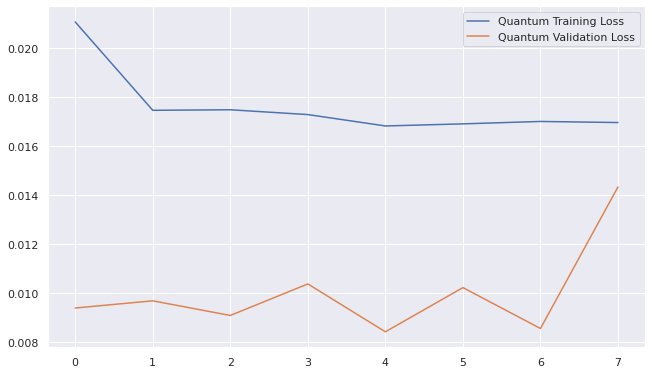

<Figure size 770.4x451.44 with 0 Axes>

In [ ]:
plt.plot(v_history.history['loss'], label='Quantum Training Loss')
plt.plot(v_history.history['val_loss'], label='Quantum Validation Loss')
plt.legend()
plt.show()
plt.savefig("predictions")

In [ ]:
errors = vqc.predict(X_val).flatten() - np.array(y_val).flatten()
actual = np.array(y_val).flatten()
predicted = vqc.predict(X_val).flatten()
# IN SAMPLE




In [ ]:
errors = vqc.predict(X_test).flatten() - np.array(y_test).flatten()
actual = np.array(y_test).flatten()
predicted = vqc.predict(X_test).flatten()
# OUT OF SAMPLE

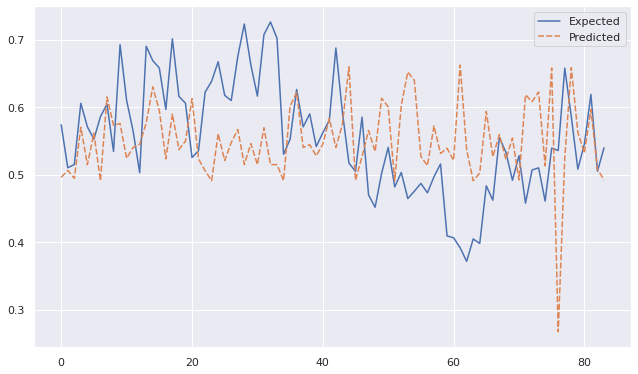

In [ ]:
results = pd.DataFrame(columns=["Expected", "Predicted"])#"Expected_Trend", "Predicted_Trend"])
results["Expected"] = actual
#results["Expected_Trend"] = results['Expected'].rolling(3).mean()

results["Predicted"] = predicted
#results["Predicted_Trend"] = results['Predicted'].rolling(3).mean()

#plt.ylim(0,5)
sns.set(rc={'figure.figsize':(10.7,6.27)})
sns.lineplot(data=results,palette="deep")#, label="Predictions")
#sns.lineplot(data = expected)#, label="Actual")

In [ ]:
errors = np.array(errors)
mape = np.mean(np.abs(errors)/actual)
rmse = np.sqrt(np.mean((np.square(errors))))
rmse_percent = rmse/np.mean(actual)
mae = np.mean(np.abs(errors))
mae_percent = np.mean(np.abs(errors))/np.mean(actual)


accuracy = 100 - 100*mape
print(f"MAPE = {mape}")
print('Accuracy:', round(accuracy, 2), '%.')
print(f"RMSE: {rmse}")
print(f"RMSE%: {rmse_percent}")
print(f"MAE: {mae}")
print(f"MAE%: {mae_percent}")
# Window = 3

MAPE = 0.14836436007630058
Accuracy: 85.16 %.
RMSE: 0.09995187566898411
RMSE%: 0.17975512382614334
MAE: 0.0801447033918206
MAE%: 0.14413357414038677
